In [20]:
# ============================================================
# 0 · Mount Google Drive
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 1 · Import Libraries
# ============================================================
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:


# ============================================================
# 2 · Load the trained Brain Tumor Model
# ============================================================
model = tf.keras.models.load_model('/content/drive/MyDrive/brain_tumor_detection_model.keras')

# ============================================================
# 3 · Image Preprocessing Function
# ============================================================
def prepare_image(path: str, img_size: int = 64) -> np.ndarray:
    """
    Load an image from disk, center-pad to square canvas of img_size×img_size,
    and return a float32 NumPy array scaled to [0,1].
    """
    img = Image.open(path).convert("RGB")
    w, h = img.size

    scale = img_size / max(w, h)
    nw, nh = int(round(w * scale)), int(round(h * scale))
    img = img.resize((nw, nh), resample=Image.BILINEAR)

    canvas = Image.new("RGB", (img_size, img_size), (0, 0, 0))
    canvas.paste(img, ((img_size - nw) // 2, (img_size - nh) // 2))

    arr = np.asarray(canvas, dtype="float32") / 255.0
    return arr

# ============================================================
# 4 · Prediction Function
# ============================================================
def predict_image(path):
    """
    Predict brain tumor presence from image, and return prediction details.
    """
    # Step 1: Prepare the image
    x = prepare_image(path, img_size=64)
    x = np.expand_dims(x, axis=0)  # Add batch dimension

    # Step 2: Predict
    prob = model.predict(x, verbose=0)[0][0]

    # Step 3: Interpret prediction
    label = "TUMOR DETECTED" if prob >= 0.9 else "NO TUMOR"

    # Step 4: Draw label on a copy of the original image
    pil_img = Image.open(path).convert("RGB")
    badge = pil_img.copy()
    draw = ImageDraw.Draw(badge)
    W, H = badge.size

    font_size = W // 12
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    text = f"{label} ({prob*100:.1f}%)"

    bbox = draw.textbbox((0, 0), text, font=font)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]

    pad, radius = 20, 18
    box = [(W - text_w)//2 - pad, H - text_h - 2*pad,
           (W + text_w)//2 + pad, H]

    color = (231, 76, 60) if label == "TUMOR DETECTED" else (46, 204, 113)
    draw.rounded_rectangle(box, radius=radius, fill=color+(200,))
    draw.text(((W - text_w)//2, H - text_h - pad), text, fill="white", font=font)

    # Step 5: Return all
    return {
        "probability": float(prob),
        "prediction": label,
        "image_with_label": badge
    }

Prediction: NO TUMOR
Probability: 0.7875


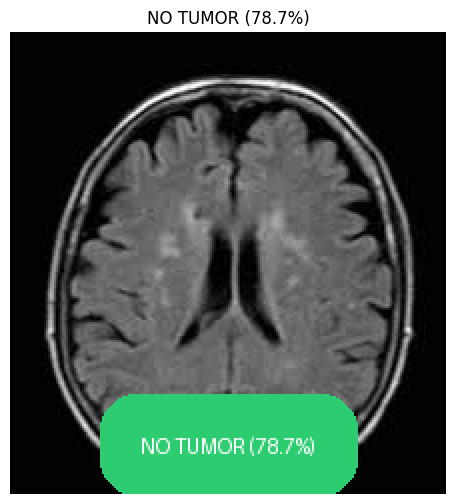

In [26]:
# ============================================================
# 5 · Example Usage
# ============================================================
# Provide a test image from your Brain Tumor dataset
path = '/content/drive/MyDrive/brain_tumor_detection_dataset/dataset/training_set/Healthy/not_cancer.jpg'  # <-- update if needed

result = predict_image(path)

# Display result
print(f"Prediction: {result['prediction']}")
print(f"Probability: {result['probability']:.4f}")

plt.figure(figsize=(6,6))
plt.imshow(result['image_with_label'])
plt.axis('off')
plt.title(f"{result['prediction']} ({result['probability']*100:.1f}%)")
plt.show()
